# 3. Managing Experiments and Hyperparameter Tuning

Now that we're a lot more familiar with the lightning API we can focus on a couple more practical aspects. In this tutorial we'll learn how to:

1. Perform multi-class classification
2. Use Weights&Biases to track experiments
3. See some more ways to measure the performance of a model
4. Learn how to perform hyperparameter tuning

In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.6 MB/s eta 0:00:00


In [1]:
import wandb
import os
from io import BytesIO
from PIL import Image
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, Callback
from lightning.pytorch.loggers import WandbLogger
import torchmetrics.classification as metrics

from typing import List

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, confusion_matrix

## Multi-Class Classification

This time we'll work on a different dataset, the [wine quality](https://archive.ics.uci.edu/dataset/186/wine+quality) dataset. This is a **multi-class classification** problem, so some things will differ (the shape of the data/preds, the loss and metrics, etc.) from how we approached the previous binary classification problems.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/djib2011/pytorch-training/refs/heads/master/data/winequality-white.csv', sep=';')

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


This dataset has 11 continuous features and the label, which has int values from 3 to 9.

Let's prepare the data.

In [3]:
X = data.drop(columns='quality')
y = data['quality'] - data['quality'].min()  # make labels start from 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape = }, {X_test.shape = }, {y_train.shape = }, {y_test.shape = }\n')
print(y.value_counts())

X_train.shape = (3673, 11), X_test.shape = (1225, 11), y_train.shape = (3673,), y_test.shape = (1225,)

quality
3    2198
2    1457
4     880
5     175
1     163
0      20
6       5
Name: count, dtype: int64


Create the data loaders...

In [4]:
# Create the training set data loader
x_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train.values)
dataset = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Create the validation set data loader
x_val_tensor = torch.from_numpy(X_test).float()
y_val_tensor = torch.from_numpy(y_test.values)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

And finally create our classifier. Here we'll change a lot of things from before:

1. Because we're dealinig with a multi-class problem, our classifier needs to have **7 outputs** (i.e. as many as the number of classes) and a **softmax** activation in its output layer.
2. Instead of a binary crossentroty **loss** we'll use the [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
3. All the model's **metrics** will change from binary to multi-class.  
4. We'll make a lot of things **configurable** from the class init (number and size of hidden layers, activation functions, optimizer, learning rate, etc.). This will help us later on when we'll try to tune these hyperparameters.

In [5]:
class WineQualityClassifier(L.LightningModule):
    INPUT_DIM = 11
    NUM_CLASSES = OUTPUT_DIM = 7

    def __init__(self, hidden_layer_sizes: List[int], hidden_layer_activation: str,
                 optimizer: str, learning_rate: float, weight_decay: float,
                 dropout_prob: float, early_stopping: bool, lr_scheduler: str):
        super().__init__()

        # Define NN layers
        prev = self.INPUT_DIM
        self.hidden = []
        for size in hidden_layer_sizes:
            self.hidden.append(nn.Linear(prev, size))
            prev = size
        self.output = nn.Linear(prev, self.OUTPUT_DIM)

        # Define activations
        self.activation = getattr(nn, hidden_layer_activation, None)()
        self.softmax = nn.Softmax(dim=1)

        # Define dropout
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(dropout_prob)

        # Store optimizer's params and lr scheduler
        self.optimizer_name = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.lr_scheduler = lr_scheduler

        # Store early stopping flag
        self.early_stopping = early_stopping

        # Define loss and metrics
        self.loss_func = nn.CrossEntropyLoss()
        self.accuracy = metrics.Accuracy(task='multiclass', num_classes=self.NUM_CLASSES)
        self.precision = metrics.Precision(task='multiclass', num_classes=self.NUM_CLASSES)
        self.recall = metrics.Recall(task='multiclass', num_classes=self.NUM_CLASSES)
        self.f1_score = metrics.F1Score(task='multiclass', num_classes=self.NUM_CLASSES)
        self.auroc = metrics.AUROC(task='multiclass', num_classes=self.NUM_CLASSES)

        # Activate save_hyperparameters flag
        self.save_hyperparameters()

    def forward(self, x):

        for layer in self.hidden:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.softmax(self.output(x))

        return x

    def training_step(self, batch, batch_idx):

        # Forward propagation
        x, y = batch
        preds = self(x)

        # Compute and log metrics
        metrics = {f'train_{name}': value for name, value in self.compute_metrics(preds, y).items()}
        self.log_dict(metrics, on_step=True,on_epoch=True, prog_bar=True)

        metrics['loss'] = metrics['train_loss']
        return metrics

    def validation_step(self, batch, batch_idx):

        # Forward propagation
        x, y = batch
        preds = self(x)

        # Compute and log metrics
        metrics = {f'val_{name}': value for name, value in self.compute_metrics(preds, y).items()}
        self.log_dict(metrics, on_epoch=True, prog_bar=True)

        metrics['preds'] = preds  # Also return preds, this will make our life easier later on
        return metrics

    def configure_optimizers(self):
        optimizer_class = getattr(optim, self.optimizer_name, None)
        optimizer = optimizer_class(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        lr_scheduler_config = self._congigure_scheduler(optimizer)

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}

    def configure_callbacks(self):

        # Define the ModelCheckpoint callback
        model_checkpoint = ModelCheckpoint(dirpath='checkpoints',
                                           filename='{epoch}-{val_f1_score:.2f}',
                                           monitor='val_f1_score',
                                           mode='max',
                                           save_top_k=1)

        # If 'early_stopping' flag is set, also add this callback
        if self.early_stopping:
            early_stopping = EarlyStopping(monitor='val_loss', mode='min')
            return [model_checkpoint, early_stopping]

        return model_checkpoint

    def _congigure_scheduler(self, optimizer):
        """
        Define a lr_scheduler_config based on the 'lr_scheduler' string provided
        during the class init.

        For most of the schedulers we'll use the default parameters.
        """

        if self.lr_scheduler == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

        elif self.lr_scheduler == 'exponential':
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

        elif self.lr_scheduler == 'cyclical':
            scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                    base_lr=self.learning_rate / 2,
                                                    max_lr=self.learning_rate * 5)

        elif self.lr_scheduler == 'reduce_on_plateau':
              scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

        else:
            # Use constant LR if no schedule is provided
            scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=1)


        lr_scheduler_config = {'scheduler': scheduler, 'interval': 'epoch', 'frequency': 1}

        return lr_scheduler_config

    def compute_metrics(self, preds, targets):
        """
        Compute loss and all metrics on a set of predictions
        """

        preds_labels = torch.argmax(preds, dim=1)

        metrics = {
            'loss': self.loss_func(preds, targets),
            'accuracy': self.accuracy(preds_labels, targets),
            'precision': self.precision(preds_labels, targets),
            'recall': self.recall(preds_labels, targets),
            'f1_score': self.f1_score(preds_labels, targets),
            'AUROC': self.auroc(preds, targets),
        }
        return metrics

To instantiate this model, we'll need to provide a lot of hyperparameters.

A few things to note regarding how it's implemented:
  - `hidden_layer_sizes` expects a **list of integers**, where the number of elements represents the **number of hidden layers** and the values represent their respective **size**. This parameter follows the design of the one in scikit-learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).
  - `hidden_layer_activation` and `optimizer` expect **strings** that need to be **exactly the same** as the names of the classes in `torch.nn` and `torch.optim` respectively. E.g. `hidden_layer_activation = 'relu'`, won't work because the name of the class is `'ReLU'` and it needs to be exactly the same.
  - `learning_rate` and `weight_decay` expect **float** values and will go directly to the optimizer object. `weight_decay=0` is equivalent to no weight decay. *Note: weight decay is just another name for L2 regularization*.
  - `dropout_prob` expects a **float** and is the value of `p` that will go to [`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). `dropout_prob=0` is equivalent to no dropout.
  - `early_stopping` expects a **bool**. Setting it to `True` will activate an `EarlyStopping` callback based on the validation loss with the default parameters. Currently there is no option to control its behavior.
  - `lr_scheduler` expects a **string**. Setting it to 'step', 'exponential', 'cyclical' or 'reduce_on_plateau' will activate a LR scheduler with the respective strategies; the parameters of each of these schedulers cannot be controled. **Any other value** will result in a constant LR throughout the training.

  We'll set a few "default" values to test how well this works.

In [6]:
hparams = dict(hidden_layer_sizes=[100],        # 1 hidden layer with 100 neurons
               hidden_layer_activation='ReLU',  # ReLU activation for hidden layer
               optimizer='Adam',                # Adam optimizer
               learning_rate=0.01,              # LR=0.01 for Adam
               weight_decay=0,                  # No weight decay
               dropout_prob=0,                  # No dropout
               early_stopping=False,            # No early stopping
               lr_scheduler=None)               # No LR scheduler

model = WineQualityClassifier(**hparams)

Let's finally train the model and see if it works.

In [7]:
trainer = L.Trainer(max_epochs=5)

trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

print(f'Validation F1: {trainer.logged_metrics["val_f1_score"]*100:.2f}%')

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Validation F1: 52.00%


## Experiment tracking through Weights&Biases

A very important, but commonly underlooked, part of ML experimentation is having a way of tracking our experiments. When conducting thorough experimentation, we have a lot of parameters we need to keep a track of: the dataset we are using, the preprocessing and augmentation steps we perform on the data, the model architecture and its hyperparameters, etc. With enough experiments, things can get out of hand and we are going to need a better way of tracking our experiments and their performance.

In this tutorial we'll see how we can use a framework called [Weights&Biases](https://wandb.ai/home)to help us out with this.

### Prerequisites

**To follow along with this tutorial you'll need to do the following steps**

- Register to [wandb.ai](https://wandb.ai/) with a free account.
- Navigate to the [authorize page](https://wandb.ai/authorize), create an API key and copy it.
- Create a file called `wandb-api-key.txt` in the same directory as this notebook and paste the key inside it.

The cell below will try to read this file and register its contents as an environment variable.

In [8]:
with open('wandb-api-key.txt') as f:
    os.environ['WANDB_API_KEY'] = f.read().replace('\n', '')

If the key is valid and added as an environment variable, wandb will successfully log you in. Alternatively, you can skip the previous step and just paste your API key when prompted.

In [9]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: canelo (canelino). Use `wandb login --relogin` to force relogin


True

In Any case, the notebook below **assumes you have successfully logged in to wandb**!

### Log metrics and register model

We'll now try to run a new experiment and log it to wandb. wandb is organized into projects, so we'll need to first define a project name to store our experiments under.

The first thing we'll need is to run `wandb.init()`. This starts a new experiment and wandb is ready to accept logs.

In [10]:
WANDB_PROJECT = 'pytorch-training-test'

wandb.init(project=WANDB_PROJECT)

There most common way of logging to wandb is to simply call `wandb.log()` and log the quantity that we want. Because we're using Lightning we have another option: the [`WandbLogger`](https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.WandbLogger.html). This is a simple logger that is added as a parameter to the trainer and automatically logs hyperparameters (as long as we have `self.save_hyperparameters()` enabled) and metrics (i.e. the ones that are logged using `self.log()` inside the model) to wandb.

In [11]:
# Create the wandb logger
wandb_logger = WandbLogger(project=WANDB_PROJECT, log_model='all')  # also register the model checkpoints

# Add it as a parameter to the trainer
trainer = L.Trainer(max_epochs=10, logger=wandb_logger)

# Train normally, all logged metrics will automatically be uploaded to wandb
trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

print(f'Validation F1: {trainer.logged_metrics["val_f1_score"]*100:.2f}%')

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation F1: 55.35%


**Important!** Once the experiment is finished, don't forget to finish the run in wandb!

In [12]:
wandb.finish()

epoch,▁▁▂▂▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇███
train_AUROC_epoch,▄▃█▅▄▁▃▇▄▄
train_AUROC_step,▆▁█
train_accuracy_epoch,▁▃▅▅▅▇▆▇▇█
train_accuracy_step,▁█▄
train_f1_score_epoch,▁▃▅▅▅▇▆▇▇█
train_f1_score_step,▁█▄
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,█▃▁
train_precision_epoch,▁▃▅▅▅▇▆▇▇█
train_precision_step,▁█▄


### Viewing our experiment in WandB

If we go to our experient's page (either via the link above or by navigating [wanb.ai]()), the first thing we'll see are the charts logged during training.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_charts.png?raw=true)

We can use the option above to filter these charts by regex

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_charts_filter.png?raw=true)

For more information on the experiment we can go to *Overview* on the bar to the left. There we'll see a lot of information on our model including

- some general information on the run

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_run_overview.png?raw=true)

- the hyperparameters registered for this experiment

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_config.png?raw=true)

- and a summary of the metrics

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_summary_metrics.png?raw=true)

### Model Registry

Along with the metrics, the model checkpoints are also stored and registered. Registering a model means tagging the model with a name and a version and associating it with the experiment so that we can track it! We can view these under *artifacts*.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_model_versions.png?raw=true)

If we want to use a model we can either do this programmatically

```python
api = wandb.Api()
artifact = api.artifact('username/project_name/model:latest', type='model')
model_dir = artifact.download()

model = torch.load(...)  # load downloaded model
```

or simply download the weights through the *Files* tab

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_model_checkpoint.png?raw=true)

### Asside: Model Evaluation

Before we continue, we'll need to discuss some things regarding model evaluation. To properly evaluate some aspects of a model's performance we might need to store and examine stuff other than scalar values (tables, images, text, audio, etc.). Some cases where we might need to do so are:

- examples of augmented images to see if **data augmentation** is meaningful
- images/text/audio produced by **generative models**
- **graphs** that help us evaluate a model's performance (e.g. ROC curve, model calibration plot)
- the **confusion matrix** of the model

We'll focus on the last two to see how we can log images and tables to wandb.

#### Model Calibration

Model calibration is a more advanced topic that we won't get into. In short, in models that output probabilities, a useful property we would like our model to have is: if it outputs a probability of for an outcome, we want this outcome to actually have a chance of occurring. E.g. if our model forecasts weather, out of all the times you said there was a chance of rain, how often did rain actually occur? (If you're interested in a deeper dive in model calibration you can read [this blog](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)).

What might interest us is plotting the model's calibration curve to see if it's predictions are calibrated or not. This can be done using scikit-learn.

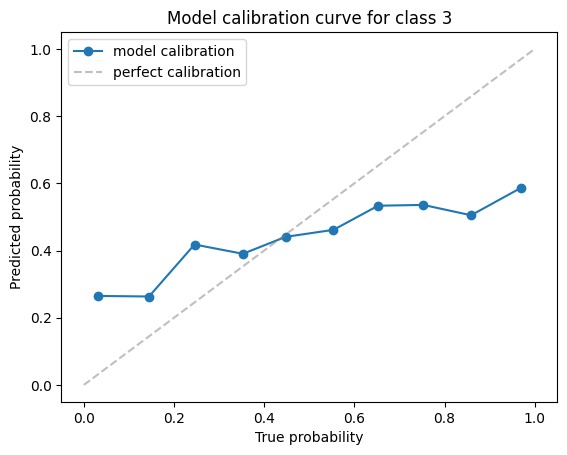

In [13]:
# Get the model's predictions
with torch.inference_mode():
    y_pred = model(x_val_tensor)

# Convert labels to one-hot
y_true_onehot = F.one_hot(y_val_tensor, num_classes=model.NUM_CLASSES)

# Calibration is meaningful on a per-class basis, we'll select a class we want to examine
class_idx = 3

# Get predictions and labels for the desired class
y_class_pred = y_pred[:, class_idx].numpy()
y_class_true = y_true_onehot[:, class_idx].numpy()

# Generate the calibration curve
prob_true, prob_pred = calibration_curve(y_class_true, y_class_pred, n_bins=10)

# Plot it
plt.plot(prob_pred, prob_true, marker='o', label='model calibration')
plt.plot([0, 1], [0, 1], color='gray', ls='--', alpha=0.5, label='perfect calibration')
plt.title(f'Model calibration curve for class {class_idx}')
plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.legend();

#### ROC Curve

The ROC (Receiver Operating Characteristic) curve is a graphical tool used to evaluate the performance of a binary classification model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings, allowing us to see the trade-offs between sensitivity (recall) and specificity. By adjusting the threshold, we can examine how well the model discriminates between the two classes.

A point closer to the upper-left corner of the ROC plot represents better model performance, as this would indicate high TPR and low FPR. The area under the ROC curve (AUC) provides a single scalar value summarizing this performance; a higher AUC value (closer to 1) generally indicates better model discrimination capabilities, with a model scoring an AUC of 0.5 performing no better than random guessing.

Similar to before, we'll use scikit-learn to generate a ROC curve.

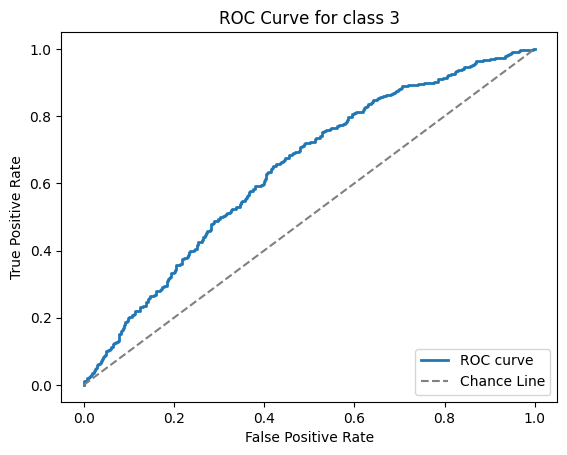

In [14]:
# Generate the ROC curve using the preds/labels for the same class as before
fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)

# Plot it
plt.plot(fpr, tpr, lw=2, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for class {class_idx}')
plt.legend(loc='lower right');

#### Confusion Matrix

A confusion matrix is a tool for evaluating classification models by comparing the actual and predicted classifications for each class. It's structured as a square matrix where rows represent the true classes and columns represent the predicted classes (or vice versa).

Again, we'll use scikit-learn to generate it.

In [15]:
# Convert preds to label format
y_pred_label = torch.argmax(y_pred, dim=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val_tensor, y_pred_label)

# Convert confusion matrix to WandB Table format
columns = [f'Pred_{i}' for i in range(conf_matrix.shape[1])]
index = [f'Label_{i}' for i in range(conf_matrix.shape[1])]

# Print it as a DataFrame
pd.DataFrame(conf_matrix, columns=columns, index=index)

,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6
Label_0,0,0,3,3,0,0,0
Label_1,0,0,26,14,1,0,0
Label_2,0,0,218,138,4,0,0
Label_3,0,0,132,403,30,0,0
Label_4,0,0,21,134,57,0,0
Label_5,0,0,3,32,5,0,0
Label_6,0,0,0,0,1,0,0


### Log images and tables

Let's return to our topic of experiment tracking. We now know how to generate *model calibration plots*, *ROC curves* and *confusion matrices*. We'll now try to generate these plots and tables **during training** and log them to wandb.

To accomplish this this we'll two main changes:
  1. Extend the model with 3 methods to generate the plots and tables
  2. Create a callback that will call these methods on specidic points during training and log their outputs to WandB

Regarding the 1st change, we'll mostly refactor the code from above into 3 methods. Some notes regarding the design:

  - I chose to make them all `staticmethods` that will accept the `y_true` and `y_pred` tensors. The reason is that I wanted to feed them the predictions from the validation loop, rather re-running the whole validation a second time.
  - The calibration plot and roc curve methods will return a lot of images (i.e. 1 for each class). The confusion matrix method will return the data for a single table.
  - There is a bit of a hassle to actually convert the matplotlib plots to images so that we can log them. We first save them to a BytesIO buffer to serialize them, then we decode the bytes into a PIL image and finally convert this to a numpy array. Because this happens for multiple images, we need be sure to clear the figure before generating a new one. I couldn't find a better way to do this, if anyone knows of a better way please let me know :)

In [16]:
class WineQualityClassifierMetrics(WineQualityClassifier):

    @staticmethod
    def plot_calibration_curves(y_true, y_pred):
        """
        Generate a plot of the model's calibration curve for each output class

        Will return a list of numpy arrays representing the the plots
        """
        y_true_onehot = F.one_hot(y_true, num_classes=WineQualityClassifier.NUM_CLASSES)

        calibration_curves = []

        for class_idx in range(WineQualityClassifier.OUTPUT_DIM):

            # Select predictions and labels for this class
            y_class_probs = y_pred[:, class_idx].detach().numpy()
            y_class_true = y_true_onehot[:, class_idx].detach().numpy()

            # Use sklearn's calibration_curve function for easy binning and mean computation
            prob_true, prob_pred = calibration_curve(y_class_true, y_class_probs, n_bins=10)

            # Plot calibration curve for this class
            plt.plot(prob_pred, prob_true, label='model calibration')
            plt.plot([0, 1], [0, 1], color='C0', ls='--', alpha=0.5, label='perfect calibration')
            plt.scatter(prob_pred, prob_true, c='C0')
            plt.title(f'Model calibration curve for class {class_idx}')
            plt.xlabel('True probability')
            plt.ylabel('Predicted probability')
            plt.legend()

            # Convert plot to bytes
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)

            # Convert bytes to array
            image = np.array(Image.open(buf).convert('RGB'))

            # Clear figure for the next one
            plt.clf()

            calibration_curves.append(image)

        return calibration_curves

    @staticmethod
    def plot_roc_curves(y_true, y_pred):
        """
        Generate a plot of the model's RoC curve for each output class

        Will return a list of numpy arrays representing the the plots
        """

        roc_curves = []

        for class_idx in range(WineQualityClassifier.OUTPUT_DIM):

            # Select predictions and labels for this class
            y_class_probs = y_pred[:, class_idx].detach().numpy()
            y_class_true = y_true_onehot[:, class_idx].detach().numpy()

            # Use sklearn's roc_curve function to compute the ROC curve values
            fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)

            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve')
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance Line')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for class {class_idx}')
            plt.legend(loc='lower right')

            # Convert plot to bytes
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)

            # Convert bytes to array
            image = np.array(Image.open(buf).convert('RGB'))

            # Clear figure for the next one
            plt.clf()

            roc_curves.append(image)

        return roc_curves

    @staticmethod
    def compute_confusion_matrix(y_true, y_pred):
        """
        Generate and return the confusion matrix data and its columns
        """

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Convert confusion matrix to WandB Table format
        columns = ['Label'] + [f'Pred_{i}' for i in range(conf_matrix.shape[1])]
        table_data = [[i] + list(row) for i, row in enumerate(conf_matrix)]

        return table_data, columns

Now it's time to create the callback. Some things to note about the design here:

- As mentioned before, I don't want to run validation a second time. For this reason, I collect the predictions/labels in each validation batch and store them for later use. Once the model's regular validation is complete, I use these predictions/labels for generating our plots/table.
- The only parameter of the callback is a variable named `log_frequency_epochs`. This allows us to control how frequently the plots/table is generated. Setting it to e.g. 5, will log the plots/table every 5 epochs.
- In the callback I call the methods that I created to generate the plots/table. This **goes against** points 1 and 3 of the [best practices](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html#best-practices) stated in the callback documentation. I'm not sure if it would have been better to implement the 3 methods inside the callback instead of the model; this is how I interpret point 1 of the best practices: *'isolated in its functionality'*. I chose against this because I feel the plots are model-specific (they require variables like `NUM_CLASSES` that I added). Again not sure if this is the best approach, but I'd be happy to discuss :)

In [17]:
class WandbLoggingCallback(Callback):
    def __init__(self, log_frequency_epochs: int = 1):
        self.freq = log_frequency_epochs
        self.all_preds = []
        self.all_labels = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        # Append predictions and labels at the end of each validation batch
        x, y = batch

        self.all_preds.extend(outputs['preds'])
        self.all_labels.extend(y)

    def on_validation_epoch_end(self, trainer, pl_module):

        # Log only every `log_frequency_epochs` (as defined in init) epochs and on the last epoch
        if (trainer.current_epoch + 1) % self.freq != 0 and trainer.current_epoch + 1 != trainer.max_epochs:
            return

        # Generate calibration and roc curves as numpy arrays
        y_true_tensor = torch.stack(self.all_labels)
        y_pred_tensor = torch.stack(self.all_preds)
        y_pred_tensor_label = torch.argmax(y_pred_tensor, dim=1)
        calibration_images = pl_module.plot_calibration_curves(y_true_tensor, y_pred_tensor)
        roc_images = pl_module.plot_roc_curves(y_true_tensor, y_pred_tensor)
        cm_table_data, cm_columns = pl_module.compute_confusion_matrix(y_true_tensor, y_pred_tensor_label)

        # Log calibration curves to WandB
        trainer.logger.log_image(
                key=f'calibration_curves',
                images=calibration_images,
                caption=[f'Calibration curve for class {i}, epoch {trainer.current_epoch}' for i in range(len(calibration_images))])

        # Log roc curves to WandB
        trainer.logger.log_image(
                key=f'roc_curves',
                images=roc_images,
                caption=[f'RoC curve for class {i}, epoch {trainer.current_epoch}' for i in range(len(roc_images))])

        # Log table to WandB
        wandb_logger.log_table(key=f'confusion_matrix_epoch_{trainer.current_epoch}', columns=cm_columns, data=cm_table_data)

        # Reset the lists after the validation phase ends, so that they can be re-filled with new data from the next validation phase
        self.all_preds = []
        self.all_labels = []

Finally, it's time to train the model using this callback.

In [18]:
# Init the wandb run
wandb.init(project=WANDB_PROJECT)

# Create the logger and callback
# Note: we need to re-initialize the logger for each wandb run
wandb_logger = WandbLogger(project=WANDB_PROJECT, log_model='all')
wandb_callback = WandbLoggingCallback(log_frequency_epochs=5)  # log every 5 epochs

# Instantiate a new model (with the 3 new methods we created)
model = WineQualityClassifierMetrics(**hparams)

# Create a trainer. Be sure to add the logger and callback to the trainer
trainer = L.Trainer(max_epochs=15, logger=wandb_logger, callbacks=[wandb_callback])

# Train the model
trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

# Don't forget to finish the run
wandb.finish()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
train_AUROC_epoch,▁▄▅▆▇▅▇▇▇▆▇▇▇▇█
train_AUROC_step,▄▁█▄
train_accuracy_epoch,▁▅▆▆▇▇▇▇▇▇█████
train_accuracy_step,▁▁█▁
train_f1_score_epoch,▁▅▆▆▇▇▇▇▇▇█████
train_f1_score_step,▁▁█▁
train_loss_epoch,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
train_loss_step,▇█▁▇
train_precision_epoch,▁▅▆▆▇▇▇▇▇▇█████
train_precision_step,▁▁█▁


<Figure size 640x480 with 0 Axes>

### Viewing our logged images and tables in WandB

If we go to the experiment page in WandB we can see the images and tables being logged there.

If you noticed, we used the same key for all the images. This leads them to be displayed in the same panel. We can control the epoch at which the images are uploaded by the slider on the bottom side.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_images.png?raw=true)

This, however, isn't available for tables, so we used different keys for each table we uploaded.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_table.png?raw=true)


### Logging other media

Besides images and tables, we can also log other media like audio, text or video, through the `WandbLogger`:

- [`log_audio`](https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.WandbLogger.html#lightning.pytorch.loggers.WandbLogger.log_audio)
- [`log_text`](https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.WandbLogger.html#lightning.pytorch.loggers.WandbLogger.log_text)
- [`log_video`](https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.WandbLogger.html#lightning.pytorch.loggers.WandbLogger.log_video)

We won't see examples of the above, if you want you can try them out on your own :)

### Tracking gradient and parameter distributions

Tracking gradients is a powerful way to gain insight into how our model is learning during training. By logging gradient values, we can monitor aspects like gradient magnitudes and distributions across layers, which helps in identifying potential issues, such as vanishing or exploding gradients.

To track gradients we will simply ask our logger to *watch* our model. WandB will display as histograms over training epochs, showing how gradients change over time.

In [21]:
wandb.init(project=WANDB_PROJECT)

model = WineQualityClassifierMetrics(**hparams)

wandb_logger = WandbLogger(project=WANDB_PROJECT, log_model='all')

# Track the model's gradients and parameters
wandb_logger.watch(model, log='all', log_freq=10)  # log_freq=10 is usually too frequent. I did it now
                                                   # just for demonstration purposes (100 is the default)

trainer = L.Trainer(max_epochs=50, logger=wandb_logger, callbacks=[wandb_callback])

trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

wandb.finish()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callba

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_AUROC_epoch,▁▄▆▆▅▇▅▄▅▇▆▅▆▇▇▇▅▆▇▇▅▇▇▇▆▇▆▇▅▆█▅▇▇▆▆▇█▆▆
train_AUROC_step,▇█▅▇▆▁▅█▁▅▅▄▅▆▇
train_accuracy_epoch,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇███▇████████████████████
train_accuracy_step,▄▄▁▆▃▇▅▆▆▅▅▆█▅▄
train_f1_score_epoch,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇█████▇█
train_f1_score_step,▄▄▁▆▃▇▅▆▆▅▅▆█▅▄
train_loss_epoch,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▇▅█▄█▂▅▄▅▅▅▄▁▄▆
train_precision_epoch,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███████████████████
train_precision_step,▄▄▁▆▃▇▅▆▆▅▅▆█▅▄


<Figure size 640x480 with 0 Axes>

The result is a graph showing how the monitored gradient and parameter distributions evolve through time. We can hover our mouse to see the histogram at a given point in time.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_histograms.png?raw=true)

## Hyperparameter Tuning

An important part of ML experimentation is identifying the correct hyperparameters (model architecture, optimizer, etc.) that work the best for the problem at hand. This process is called hyperparameter tuning (HPT).

While it is possible to perform HPT ourselves (i.e. iteratively train and evaluate models with different hyperparameters), it is much better to use a tool to help us out. Besides convenience, some tools also offer more advanced strategies for searching through the possible hyperparameters.

The tool we'll use to perform HPT is [WandB Sweeps](https://docs.wandb.ai/guides/sweeps/).

### Grid Search

The easiest thing to do perform what is called a *Grid Search*. In this process, we will define a set of values that we want to examine for each hyperparameter and test **all possible combinations** between these values. This approach was popularized by scikit-learn's [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

The first thing we need to do is to define the values of the hyperparameters we want to search. For this example, let's say we want to tune the model's architecture (i.e. the size of the hidden layer and its activation function); we'll keep just 1 hidden layer to make things easier for us.

In [ ]:
parameters_dict = {
      'hidden_layer_sizes': {
          'values': [[50], [100], [200]]},  # 1 hidden layers of 50/100/200 neurons
      'hidden_layer_activation': {
          'values': ['ReLU', 'LeakyReLU', 'PReLU']}}  # different activation functions

With the above dict, we speficy to WandB that we want to search over 9 different combinations

.       || | activation=ReLU | activation=LeakyReLU | activation=PReLU
---     || | ---  |    ---    |  ---
size=50 || |   1  |     2     |    3  
size=100|| |   4  |     5     |    6  
size=200|| |   7  |     8     |    9  

Besides these we might also want to set the other hyperparameters to fixed values.

*Note: This isn't strictly necessary as we can set them manually when instantiating the model. It arguably helps, though, by making the `build_model` factory more modular.*

In [ ]:
default_parameters = {'optimizer': {'value': 'Adam'},
                      'learning_rate': {'value': 0.01},
                      'weight_decay': {'value': 0},
                      'dropout_prob': {'value': 0},
                      'early_stopping': {'value': False},
                      'lr_scheduler': {'value': None}}

parameters_dict.update(default_parameters)

Now we need to define the **sweep configuration**. This lets WandB know what strategy we are going to use and what metric we are interested in optimizing. For the different options regarding sweeps you can refer to [the sweep config documentation](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/).

In [ ]:
sweep_config = {
  'method': 'grid',  # grid search through all possible hparam combinations
  'metric': {
      'name': 'val_loss',  # judge hyperparameters based on 'val_loss' metric
      'goal': 'minimize'   # lower values of 'val_loss' are better
  },
  'parameters': parameters_dict  # values for the hyperparameters
}

To actually run the sweep we'll need one more thing: a function that sets up and runs the experiment.

This function needs to:
  - create the model based on the parameters provided by a config
  - init the wandb experiment
  - run training/validation
  - log the model's hyperparameters (either via `wandb.init(config=config)` or as we're doing it via `self.save_hyperparameters()` inside the model; just not both)
  - log the metric we are asking the sweep to monitor (i.e. `val_loss` in our example)
  - optionally log any other metrics or media we want
  - finish the experiment

This function will be called by a WandB agent to run the HPT.

In [ ]:
def build_model_from_config(config):
    """
    Factory function that instantiates a model based on values provided by a config
    """
    return WineQualityClassifierMetrics(hidden_layer_sizes=config.hidden_layer_sizes,
                                        hidden_layer_activation=config.hidden_layer_activation,
                                        optimizer=config.optimizer,
                                        learning_rate=config.learning_rate,
                                        weight_decay=config.weight_decay,
                                        dropout_prob=config.dropout_prob,
                                        early_stopping=config.early_stopping,
                                        lr_scheduler=config.lr_scheduler)


def run_experiment(config=None):
    """
    Main function to run a WandB experiment
    """

    with wandb.init() as run:  # If we use wandb.init() as a context manager we don't need to finish the run

      config = wandb.config  # If called by wandb.agent, this config will be set by Sweep Controller

      model = build_model_from_config(config)

      trainer = L.Trainer(max_epochs=5)  #  We won't use the logger, so nothing from the model side will be logged

      trainer.fit(model=model,
                  train_dataloaders=train_loader,
                  val_dataloaders=val_loader)

      run.log({'val_loss': trainer.logged_metrics['val_loss']})  # We need to log the metric that WandB will monitor though

*Note: At the time of this writing (Nov 2024) there is a bug which doesn't allow us to use the `WandbLogger` with sweeps, so for now we'll ignore.*

We now need to setup the sweep.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: syiuadvd
Sweep URL: https://wandb.ai/canelino/pytorch-training-test/sweeps/syiuadvd


And finally run it through the [sweep agent](https://docs.wandb.ai/guides/sweeps/start-sweep-agents).

This will run the whole HPT loop so it will take a while...

In [ ]:
wandb.agent(sweep_id, run_experiment)

wandb: Agent Starting Run: q8uujcva with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [50]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.66749


wandb: Agent Starting Run: xkz09q6n with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | ReLU                | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.6414


wandb: Agent Starting Run: k3f31eal with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | ReLU                | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.62826


wandb: Agent Starting Run: tr1jm75o with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [50]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 357    | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.66203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0u6hms7 with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.63809


wandb: Agent Starting Run: q28m8vfe with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.62471


wandb: Agent Starting Run: bajrc8mj with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [50]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 357    | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.65523


wandb: Agent Starting Run: e3r7bmd8 with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.63568


wandb: Agent Starting Run: iv3ov8iw with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.62415


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Viewing Sweep Results

If we head to the sweep's page in WandB we can see that a few charts have been created that compare the runs.

The first thing we'll see is a bar plot comparing the monitored metric (i.e. `val_loss`) for the different runs.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_sweep_bar.png?raw=true)

Also three other figures were generated that we haven's seen before:

- A [scatter plot](https://docs.wandb.ai/guides/app/features/panels/scatter-plot/) comparing the time the experiment was run with the monitored metric.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_sweep_scatter.png?raw=true)

This is helpful to give a **big picture** on if our experiments are improving the desired metric over a longer time, e.g.

![](https://docs.wandb.ai/assets/images/scatter-plots-1-5913c759d33f5ffb21b95268e576c972.png)

- A [parameter importance](https://docs.wandb.ai/guides/app/features/panels/parameter-importance/) plot showing the relative importance of each hyperparer to the monitored metric

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_sweep_importance.png?raw=true)

This is helpful to determine which hyperparameters are **more important to tune** than others in a subsequent sweep.

- And finally a [parallel coordinates](https://docs.wandb.ai/guides/app/features/panels/parallel-coordinates/) plot showing the scores that each parameter combination led to.

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_sweep_parallel.png?raw=true)

This is helpful to sumarize the **relationship between different hyperparameters**.

You can also read the WandB page for [visualizing sweep results](https://docs.wandb.ai/guides/sweeps/visualize-sweep-results).



### Advanced HPT strategies

Grid search is a brute-force way of searching through hyperparameters. It is **not** the best approach when we have a **large number of parameter combinations** to search through.

In these cases we need more intelligent ways of searching through the hyperparameter space.The most popular such strategy is **Baysian Optimization** [$^1$](https://arxiv.org/pdf/1807.02811). This trains a probabilistic model (often a Gaussian Process) to predict the performance score associated with the different hyperparameters. Based on this model, Bayesian optimization intelligently chooses new sets of hyperparameters that are most likely to improve performance.

To setup bayesian optimization we can set [`method='bayesian'`](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/#bayesian-search) in the sweep config. We can configure the distribution of the baysian optimization through the [`distribution`](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/#distribution-options-for-random-and-bayesian-search) option of the config.

The example below uses another approach. It combines a **randomized search** (which is exactly what is sound like) with an intelligent algorithm for [early stopping](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/#early_terminate) called **Hyperband** [$^2$](https://arxiv.org/pdf/1603.06560).

### Advanced grid search example

**Important note**: The cells below are meant for demonstration puroposes. Do not run them (especially the agent), because it will take multiple hours to finish!

First, we'll define the hyperband config. For more info on how to set this up you can refer to [the sweep config documentation](https://docs.wandb.ai/guides/sweeps/sweep-config-keys).

In [ ]:
sweep_config = {
  'method': 'random',
  'metric': {
      'name': 'val_auroc',
      'goal': 'maximize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'hidden_layer_sizes': {
          'values': [[50], [100], [200],                             # 1 hidden layer
                     [50, 25], [100, 50], [200, 100],                # 2 hidden layers
                     [50, 25, 10], [100, 50, 25], [200, 100, 50]]},  # 3 hidden layers
      'hidden_layer_activation':{
          'values': ['ReLU', 'Sigmoid', 'LeakyReLU', 'PReLU']},
      'optimizer': {
          'values': ['Adam', 'AdamW', 'SGD']},
      'learning_rate': {
          'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]},
      'weight_decay': {
          'values': [0, 0.0001, 0.001, 0.1]},
      'dropout_prob': {
          'values': [0, 0.25, 0.5]},
      'early_stopping': {
          'values': [True, False]},
      'lr_scheduler': {
          'values': ['None', 'step', 'exponential', 'cyclical', 'reduce_on_plateau']}
  }
}

Then slightly change our `run_experiment` function from before to log all metrics at the end of training.

In [ ]:
def run_experiment(config=None):

    with wandb.init() as run:

      config = wandb.config

      model = build_model_from_config(config)

      trainer = L.Trainer(max_epochs=50)

      trainer.fit(model=model,
                  train_dataloaders=train_loader,
                  val_dataloaders=val_loader)

      run.log(trainer.logged_metrics)

Init the sweep...

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: 1xxcmrjn
Sweep URL: https://wandb.ai/canelino/pytorch-training-test/sweeps/1xxcmrjn


And run the agent...

In [ ]:
wandb.agent(sweep_id, run_experiment, count=500)

wandb: Agent Starting Run: j8meuhcn with config:
wandb: 	dropout_prob: 0.5
wandb: 	early_stopping: True
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: exponential
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.1


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


train_AUROC_epoch,▁
train_AUROC_step,▁
train_accuracy_epoch,▁
train_accuracy_step,▁
train_f1_score_epoch,▁
train_f1_score_step,▁
train_loss_epoch,▁
train_loss_step,▁
train_precision_epoch,▁
train_precision_step,▁
train_recall_epoch,▁


wandb: Agent Starting Run: c4ptxyrb with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.001
wandb: 	lr_scheduler: step
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.1


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


train_AUROC_epoch,▁
train_AUROC_step,▁
train_accuracy_epoch,▁
train_accuracy_step,▁
train_f1_score_epoch,▁
train_f1_score_step,▁
train_loss_epoch,▁
train_loss_step,▁
train_precision_epoch,▁
train_precision_step,▁
train_recall_epoch,▁


wandb: Agent Starting Run: vml5ezl1 with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: True
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [200, 100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: cyclical
wandb: 	optimizer: AdamW
wandb: 	weight_decay: 0.001


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

#### Results

![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_sweep_results_1.png?raw=true)


![](https://github.com/djib2011/pytorch-training/blob/master/figures/wandb_sweep_results_2.png?raw=true)
